In [9]:
# 导入必要的库
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms, models, utils
from torchsummary import summary # 可视化训练过程
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from PIL import Image

In [10]:
# 分为train，val，test定义transform
image_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size=300, scale=(0.8, 1.1)), # 功能：随机长宽比裁剪原始图片，表示随机crop出来的图片会在0.08倍至1.1倍之间
        transforms.RandomRotation(degrees=10), #功能：根据degrees随机旋转一定角度，表示在（-10，10）度之间随机旋转
        transforms.ColorJitter(0.4, 0.4, 0.4), #功能：修改亮度、对比度和饱和度
        transforms.RandomHorizontalFlip(), #功能：水平翻转
        transforms.CenterCrop(size=256), #根据给定的size从中心裁剪，size - 若为sequence，则为（h，w），若为int，则为（size，size）
        transforms.ToTensor(), #numpy --> tensor
        # 功能：对数据按通道进行标准化（RGB），即先减均值，再除以标准差
        transforms.Normalize([0.485, 0.456, 0.406], # mean
                             [0.229, 0.224, 0.225]) # std
        ]),

    'val':
        transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], # mean
                                 [0.229, 0.224, 0.225]) # std
        ]),

    'test':
        transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], # mean
                                 [0.229, 0.224, 0.225]) # std
        ]),
}

In [11]:
# 加载数据集

# 数据集所在目录路径
data_dir = './chest_xray/'
# train路径
train_dir = data_dir + 'train/'
# val路径
val_dir = data_dir + 'val/'
# test路径
test_dir = data_dir + 'test/'

# 从文件中读取数据
datasets = {
    'train' : datasets.ImageFolder(train_dir, transform=image_transforms['train']), # 读取train中的数据集，并transform
    'val' : datasets.ImageFolder(val_dir, transform=image_transforms['val']), # 读取val中的数据集，并transform
    'test' : datasets.ImageFolder(test_dir, transform=image_transforms['test']) # 读取test中的数据集，并transform
}

# 定义BATCH_SIZE
BATCH_SIZE = 128 # 每批读取128张图片

# DataLoader ：创建iterator，按批读取数据
dataloaders = {
    'train' : DataLoader(datasets['train'], batch_size=BATCH_SIZE, shuffle=True), # 训练集
    'val' : DataLoader(datasets['val'], batch_size=BATCH_SIZE, shuffle=True), # 验证集
    'test' : DataLoader(datasets['test'], batch_size=BATCH_SIZE, shuffle=True) # 测试集
}

# 创建label的键值对
LABEL = dict((v, k) for k, v in datasets['train'].class_to_idx.items())

LABEL

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [12]:
# train 简介
dataloaders['train'].dataset

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: ./chest_xray/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(300, 300), scale=(0.8, 1.1), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [13]:
dataloaders['train'].dataset.classes # train下的类别

['NORMAL', 'PNEUMONIA']

In [14]:
dataloaders['train'].dataset.root # train下的路径

'./chest_xray/train/'

In [15]:
# 肺部正常的图片
files_normal = os.listdir(os.path.join(str(dataloaders['train'].dataset.root), 'NORMAL'))
files_normal

['IM-0115-0001.jpeg',
 'IM-0117-0001.jpeg',
 'IM-0119-0001.jpeg',
 'IM-0122-0001.jpeg',
 'IM-0125-0001.jpeg',
 'IM-0127-0001.jpeg',
 'IM-0128-0001.jpeg',
 'IM-0129-0001.jpeg',
 'IM-0131-0001.jpeg',
 'IM-0133-0001.jpeg',
 'IM-0135-0001.jpeg',
 'IM-0137-0001.jpeg',
 'IM-0140-0001.jpeg',
 'IM-0141-0001.jpeg',
 'IM-0143-0001.jpeg',
 'IM-0145-0001.jpeg',
 'IM-0147-0001.jpeg',
 'IM-0149-0001.jpeg',
 'IM-0151-0001.jpeg',
 'IM-0152-0001.jpeg',
 'IM-0154-0001.jpeg',
 'IM-0156-0001.jpeg',
 'IM-0158-0001.jpeg',
 'IM-0160-0001.jpeg',
 'IM-0162-0001.jpeg',
 'IM-0164-0001.jpeg',
 'IM-0166-0001.jpeg',
 'IM-0168-0001.jpeg',
 'IM-0170-0001.jpeg',
 'IM-0172-0001.jpeg',
 'IM-0176-0001.jpeg',
 'IM-0177-0001.jpeg',
 'IM-0178-0001.jpeg',
 'IM-0180-0001.jpeg',
 'IM-0182-0001.jpeg',
 'IM-0183-0001.jpeg',
 'IM-0185-0001.jpeg',
 'IM-0187-0001.jpeg',
 'IM-0189-0001.jpeg',
 'IM-0191-0001.jpeg',
 'IM-0193-0001.jpeg',
 'IM-0195-0001.jpeg',
 'IM-0199-0001.jpeg',
 'IM-0201-0001.jpeg',
 'IM-0203-0001.jpeg',
 'IM-0205-

In [16]:
# 肺部感染的图片
files_pneumonia = os.listdir(os.path.join(str(dataloaders['train'].dataset.root), 'PNEUMONIA'))
files_pneumonia

['person1000_bacteria_2931.jpeg',
 'person1000_virus_1681.jpeg',
 'person1001_bacteria_2932.jpeg',
 'person1002_bacteria_2933.jpeg',
 'person1003_bacteria_2934.jpeg',
 'person1003_virus_1685.jpeg',
 'person1004_bacteria_2935.jpeg',
 'person1004_virus_1686.jpeg',
 'person1005_bacteria_2936.jpeg',
 'person1005_virus_1688.jpeg',
 'person1006_bacteria_2937.jpeg',
 'person1007_bacteria_2938.jpeg',
 'person1007_virus_1690.jpeg',
 'person1008_bacteria_2939.jpeg',
 'person1008_virus_1691.jpeg',
 'person1009_virus_1694.jpeg',
 'person100_virus_184.jpeg',
 'person1010_bacteria_2941.jpeg',
 'person1010_virus_1695.jpeg',
 'person1011_bacteria_2942.jpeg',
 'person1012_bacteria_2943.jpeg',
 'person1014_bacteria_2945.jpeg',
 'person1015_virus_1701.jpeg',
 'person1015_virus_1702.jpeg',
 'person1016_bacteria_2947.jpeg',
 'person1016_virus_1704.jpeg',
 'person1017_bacteria_2948.jpeg',
 'person1018_bacteria_2949.jpeg',
 'person1018_virus_1706.jpeg',
 'person1019_bacteria_2950.jpeg',
 'person1019_virus_17

In [17]:
# val 简介
dataloaders['val'].dataset

Dataset ImageFolder
    Number of datapoints: 16
    Root location: ./chest_xray/val/
    StandardTransform
Transform: Compose(
               Resize(size=300, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [18]:
# test 简介
dataloaders['test'].dataset

Dataset ImageFolder
    Number of datapoints: 624
    Root location: ./chest_xray/test/
    StandardTransform
Transform: Compose(
               Resize(size=300, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


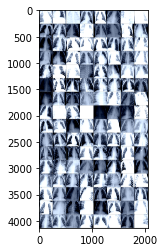

In [19]:
# 导入SummaryWriter
from torch.utils.tensorboard import SummaryWriter
# SummaryWriter() 向事件文件写入事件和概要

# 定义日志路径
log_path = 'logdir/'

# 定义函数：获取tensorboard writer
def tb_writer():
    timestr = time.strftime("%Y%m%d_%H%M%S") # 时间格式
    writer = SummaryWriter(log_path+timestr) # 写入日志
    return writer


writer = tb_writer()

# 第1种方法：显示部分图片集 
images, labels = next(iter(dataloaders['train'])) # 获取到一批数据

# 定义图片显示方法
def imshow(img):
    img = img / 2 + 0.5 # 逆正则化
    np_img = img.numpy() # tensor --> numpy
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # 改变通道顺序
    plt.show()
    
grid = utils.make_grid(images) # make_grid的作用是将若干幅图像拼成一幅图像
imshow(grid) # 展示图片

# 在summary中添加图片数据
writer.add_image('X-Ray grid', grid, 0) # add_image(tag, img_tensor, global_step=None, walltime=None, dataformats='CHW')

writer.flush() # 把事件写入到磁盘

In [20]:
# 获取一张图片tensor
dataloaders['train'].dataset[4] # 返回：tensor，label

(tensor([[[-0.1828, -0.2684, -0.3198,  ..., -0.7822, -0.7137, -0.6281],
          [-0.1828, -0.2342, -0.3883,  ..., -0.7308, -0.6965, -0.7137],
          [-0.2513, -0.2342, -0.3883,  ..., -0.7137, -0.7137, -0.7137],
          ...,
          [ 0.8789,  0.8618,  0.9303,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.8789,  0.8618,  0.9988,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.8618,  0.9303,  0.9474,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-0.0574, -0.1450, -0.1975,  ..., -0.6702, -0.6001, -0.5126],
          [-0.0574, -0.1099, -0.2675,  ..., -0.6176, -0.5826, -0.6001],
          [-0.1275, -0.1099, -0.2675,  ..., -0.6001, -0.6001, -0.6001],
          ...,
          [ 1.0280,  1.0105,  1.0805,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.0280,  1.0105,  1.1506,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.0105,  1.0805,  1.0980,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[ 0.1651,  0.0779,  0.0256,  ..., -0.4450, -0.3753, -0.2881],
          [ 0.1651,  0.1128,

Label :  NORMAL


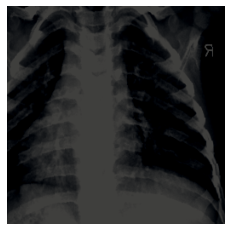

In [21]:
# 第2种方法：显示一张图片
def show_sample(img, label):
    print("Label : ", dataloaders['train'].dataset.classes[label]) # 输出标签
    img = img.numpy().transpose((1, 2, 0)) # 改变shape顺序
    mean = np.array([0.485, 0.456, 0.406]) # 均值
    std = np.array([0.229, 0.224, 0.225]) # 标准差
    img = img * std * mean # 逆向复原
    img = np.clip(img, 0, 1) # np.clip（） 将inp中的元素值限制在（0，1）之间，最小值为0，最大值为1。小于min的等于min，大于max等于max
    plt.imshow(img)
    plt.axis('off') # 关闭坐标轴
    
show_sample(*dataloaders['train'].dataset[4]) # 显示第5张图片

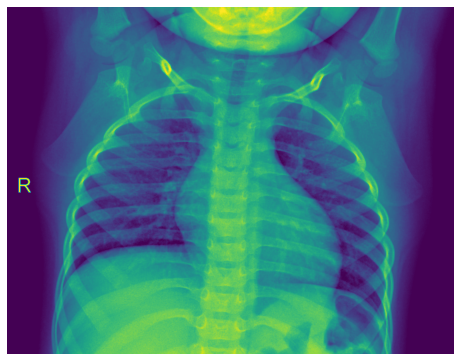

In [22]:
#  第3种方法：显示一张图片
def show_image(img):
    plt.figure(figsize=(8,8)) # 显示大小
    plt.imshow(img) # 显示图片
    plt.axis('off') # 关闭坐标轴
    plt.show()
    
# 读取图片
one_img = Image.open(dataloaders['train'].dataset.root+'NORMAL/IM-0239-0001.jpeg')

# 调用函数
show_image(one_img)

In [23]:
# 记录错误分类的图片
def misclassified_images(pred, writer, target, images, output, epoch, count=10):
    misclassified = (pred != target.data) # 判断是否一致
    for index, image_tensor in enumerate(images[misclassified][:count]):
        img_name = 'Epoch:{}-->Predict:{}-->Actual:{}'.format(epoch, LABEL[pred[misclassified].tolist()[index]],
                                                             LABEL[target.data[misclassified].tolist()[index]])
        writer.add_image(img_name, image_tensor, epoch)

In [24]:
# 自定义池化层

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, size=None):
        super(AdaptiveConcatPool2d, self).__init__()
        size = size or (1, 1) # kernel大小
        # 自适应算法能够自动帮助我们计算核的大小和每次移动的步长。
        self.avgPooling = nn.AdaptiveAvgPool2d(size) # 自适应平均池化
        self.maxPooling = nn.AdaptiveAvgPool2d(size) # 最大池化
    def forward(self, x):
        # 拼接avg和max
        return torch.cat([self.maxPooling(x), self.avgPooling(x)], dim=1)

In [25]:
# 迁移学习：获取预训练模型，并替换池化层和全连接层
def get_model():
    # 获取预训练模型 restnet50
    model = models.resnet50(pretrained=True)
    # 冻结模型参数
    for param in model.parameters():
        param.requires_grad = False
    # 替换最后2层：池化层和全连接层
    # 池化层
    model.avgpool = AdaptiveConcatPool2d()
    # 全连接层
    model.fc = nn.Sequential(
        nn.Flatten(), # 拉平
        nn.BatchNorm1d(4096), # 加速神经网络的收敛过程，提高训练过程中的稳定性
        nn.Dropout(0.5), # 丢掉部分神经元
        nn.Linear(4096, 512), # 全连接层
        nn.ReLU(), # 激活函数
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, 2), # 2个输出
        nn.LogSoftmax(dim=1) # 损失函数：将input转换成概率分布的形式，输出2个概率
    )
    return model

In [26]:
# 定义训练函数
def train_val(model, device, train_loader, val_loader, optimizer, criterion, epoch, writer):
    model.train()
    total_loss = 0.0
    val_loss = 0.0
    val_acc = 0
    for batch_id, (images, labels) in enumerate(train_loader):
        # 部署到device上
        images, labels = images.to(device), labels.to(device)
        # 梯度置0
        optimizer.zero_grad()
        # 模型输出
        outputs = model(images)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 累计损失
        total_loss += loss.item() * images.size(0)
    # 平均训练损失
    train_loss = total_loss / len(train_loader.dataset)
    # 写入到writer中
    writer.add_scalar('Training Loss', total_loss, epoch)
    # 写入到磁盘
    writer.flush()
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # 前向传播输出
            loss = criterion(outputs, labels) # 损失
            val_loss += loss.item() * images.size(0) # 累计损失
            _, pred = torch.max(outputs, dim=1) # 获取最大概率的索引
            correct = pred.eq(labels.view_as(pred)) # 返回：tensor([True, False, True, ..., False])
            accuracy = torch.mean(correct.type(torch.FloatTensor)) # 准确率
            val_acc += accuracy.item() * images.size(0) # 累计准确率
        # 平均验证损失
        val_loss = val_loss / len(val_loader.dataset)
        # 平均准确率
        val_acc = val_acc / len(val_loader.dataset)
        
    return train_loss, val_loss, val_acc

In [27]:
# 定义测试函数
def test(model, device, test_loader, criterion, epoch, writer):
    model.eval()
    total_loss = 0.0
    correct = 0.0 # 正确数
    with torch.no_grad():
        for batch_id, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            # 输出
            outputs = model(images)
            # 损失
            loss = criterion(outputs, labels)
            # 累计损失
            total_loss += loss.item()
            # 获取预测概率最大值的索引
            _, predicted = torch.max(outputs, dim=1)
            # 累计正确预测的数
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            # 错误分类的图片
            misclassified_images(predicted, writer, labels, images, outputs, epoch)
        # 平均损失
        avg_loss = total_loss / len(test_loader.dataset)
        # 计算正确率
        accuracy = 100 * correct / len(test_loader.dataset)
        # 将test的结果写入writer
        writer.add_scalar("Test Loss", total_loss, epoch)
        writer.add_scalar("Accuracy", accuracy, epoch)
        writer.flush()
        return total_loss, accuracy

In [28]:
# 定义训练流程

# 是否有GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device.type)

# 模型部署到device
model = get_model().to(device)

# 损失函数
criterion = nn.NLLLoss()

# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.001)

# 定义训练流程函数
def train_epochs(model, device, dataloaders, criterion, optimizer, epochs, writer):
    # 输出信息
    print("{0:>15} | {1:>15} | {2:>15} | {3:>15} | {4:>15} | {5:>15}".format('Epoch', 'Train Loss', 'val_loss', 'val_acc', 'Test Loss', 'Test_acc'))
    # 初始最小的损失
    best_loss = np.inf
    # 开始训练、测试
    for epoch in range(epochs):
        # 训练，return：loss
        train_loss, val_loss, val_acc = train_val(model, device, dataloaders['train'], dataloaders['val'], optimizer, criterion, epoch, writer)
        # 测试，return：loss + accuracy
        test_loss, test_acc = test(model, device, dataloaders['test'], criterion, epoch, writer)
        # 判断损失是否最小
        if test_loss < best_loss:
            best_loss = test_loss # 保存最小损失
            # 保存模型
            torch.save(model.state_dict(), 'model.pth')
        # 输出结果
        print("{0:>15} | {1:>15} | {2:>15} | {3:>15} | {4:>15} | {5:>15}".format(epoch, train_loss, val_loss, val_acc, test_loss, test_acc))
        writer.flush()

cuda


In [37]:
# 调用函数
epochs = 10 # 训练10轮
train_epochs(model, device, dataloaders, criterion, optimizer, epochs, writer)
writer.close()

          Epoch |      Train Loss |        val_loss |         val_acc |       Test Loss |        Test_acc
              0 | 0.6825209340434865 | 0.5422725081443787 |           0.625 | 2.595220625400543 |            75.0
              1 | 0.558131769756598 | 0.43085676431655884 |          0.8125 | 2.1404412388801575 | 82.05128205128206
              2 | 0.48210826223613296 | 0.399838924407959 |          0.8125 | 2.0272105932235718 | 83.49358974358974
              3 | 0.4460967894346436 | 0.38107556104660034 |          0.8125 | 1.968153178691864 | 83.81410256410257
              4 | 0.4331322262989231 | 0.3716253936290741 |           0.875 | 1.9147186875343323 | 84.2948717948718
              5 | 0.40608766638428156 | 0.36476457118988037 |          0.8125 | 1.8702184855937958 | 85.41666666666667
              6 | 0.40256036516347543 | 0.36465394496917725 |          0.8125 | 1.8773267567157745 | 85.09615384615384
              7 | 0.39266886173581783 | 0.36034324765205383 |          0.81

In [38]:
def plot_confusion(cm):
    plt.figure()
    plot_confusion_matrix(cm, figsize=(12, 8), cmap=plt.cm.Blues) # 参数设置
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
    plt.yticks(range(2), ['Normal', 'pneumonia'], fontsize=14)
    plt.xlabel('predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.show()

In [39]:
def accuracy(outputs, labels):
    # 计算正确率
    _, preds = torch.max(outputs, dim=1)
    correct = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    return correct

In [40]:
def metrics(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    # precsion, recall, F1
    # 混淆矩阵
    cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
    # 绘制混淆矩阵
    plot_confusion(cm)
    # 获取tn，fp，fn，tp
    tn, fp, fn, tp = cm.ravel()
    # 精准率
    precision = tp / (tp + fp)
    # 召回率
    recall = tp / (tp + fn)
    # f1 score
    f1 = 2 * ((precision * recall) / (precision + recall))
    return precision, recall, f1

<Figure size 432x288 with 0 Axes>

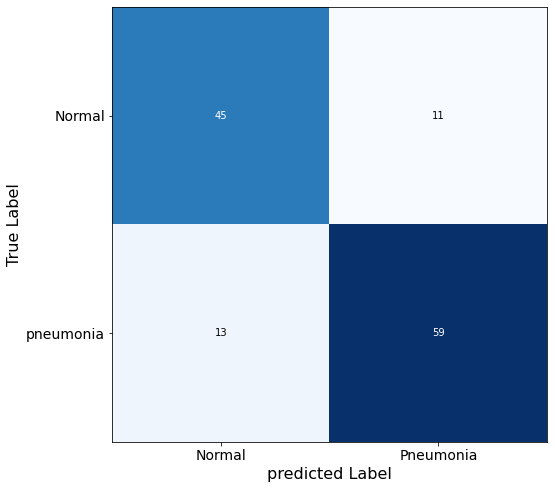

<Figure size 432x288 with 0 Axes>

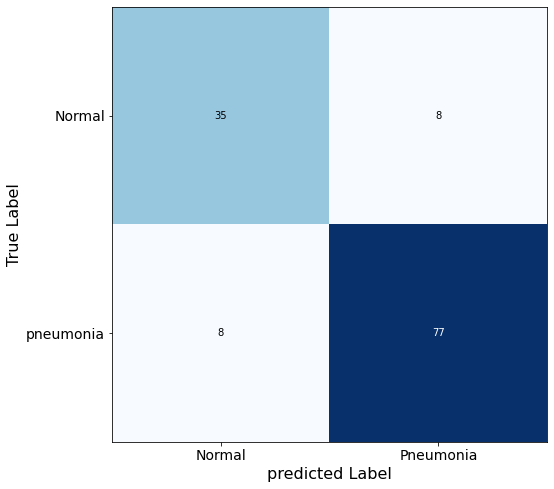

<Figure size 432x288 with 0 Axes>

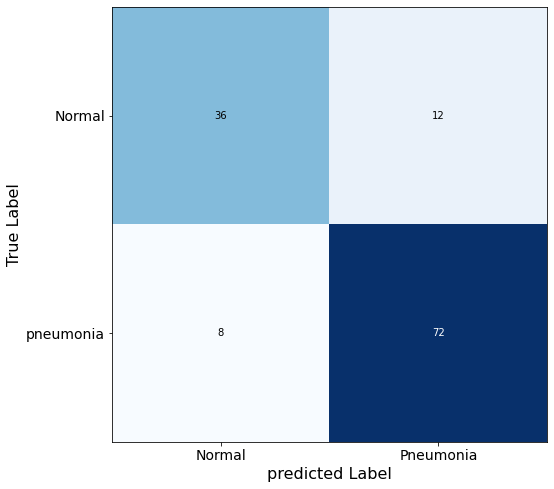

<Figure size 432x288 with 0 Axes>

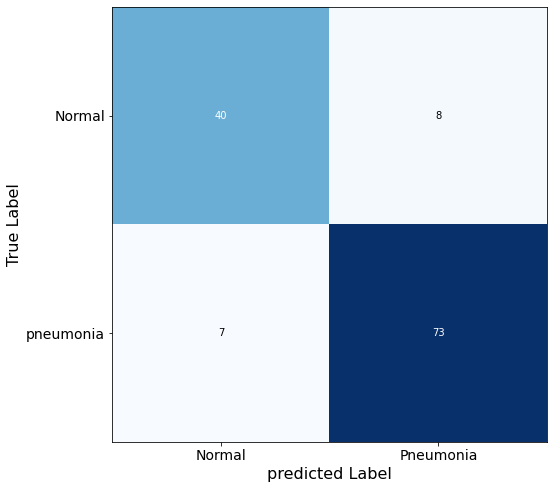

<Figure size 432x288 with 0 Axes>

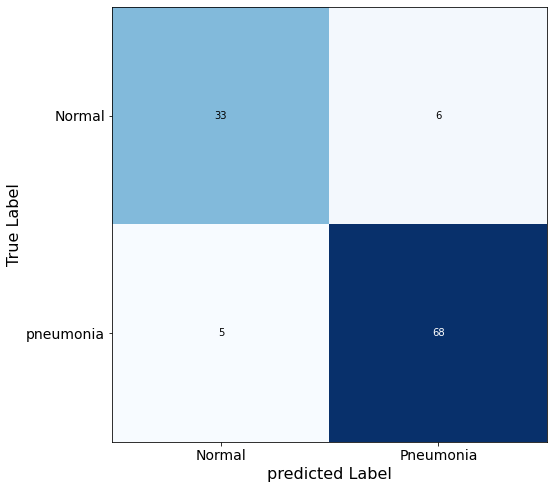

In [41]:
# 计算testloader
precisions = []
recalls = []
f1s = []
accuracies = []

with torch.no_grad():
    model.eval()
    for datas, labels in dataloaders['test']:
        datas, labels = datas.to(device), labels.to(device)
        # 预测输出
        outputs = model(datas)
        # 计算metrics
        precision, recall, f1 = metrics(outputs, labels)
        acc = accuracy(outputs, labels)
        # 保存结果
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        accuracies.append(acc.item())

In [42]:
['{:.2f}%'.format(pre*100) for pre in precisions] # 精准率 precision

['84.29%', '90.59%', '85.71%', '90.12%', '91.89%']

In [43]:
['{:.2f}%'.format(r*100) for r in recalls] # 召回率 recall

['81.94%', '90.59%', '90.00%', '91.25%', '93.15%']

In [44]:
['{:.2f}%'.format(f*100) for f in f1s] # f1

['83.10%', '90.59%', '87.80%', '90.68%', '92.52%']

In [45]:
['{:.2f}%'.format(a*100) for a in accuracies] # 准确率 accuracy

['81.25%', '87.50%', '84.38%', '88.28%', '90.18%']